In [ ]:
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Tuple, Union
from collections import defaultdict


In [ ]:
# =============================================================================
# DATA LOADING
# =============================================================================

def load_experiment_data(
    base_filepath: Union[str, Path],
    filename: str,
    hybrid_run_ids: List[str],
    pose_run_ids: List[str],
    verbose: bool = True
) -> Tuple[List[Dict], List[Dict]]:
    """
    Load pose and LCLoP (hybrid) experiment data from multiple seeds.
    
    Loads from: {base_filepath}/{hybrid|pose}/{run_id}/{filename}
    
    Args:
        base_filepath: Base directory containing 'hybrid' and 'pose' subdirectories.
        filename: Name of pickle file (e.g., 'traj_2995200.pkl').
        hybrid_run_ids: List of run IDs for hybrid/LCLoP experiments (e.g., ['run_1', 'run_2', ...]).
        pose_run_ids: List of run IDs for pose control experiments.
        verbose: Print summary statistics after loading.
    
    Returns:
        Tuple of (episode_data, break_events) formatted for plotting functions.
    
    Example:
        episode_data, break_events = load_experiment_data(
            base_filepath='/path/to/experiments',
            filename='traj_2995200.pkl',
            hybrid_run_ids=['seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4'],
            pose_run_ids=['seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4']
        )
    """
    base_filepath = Path(base_filepath)
    
    episode_data = []
    break_events = []
    
    # Track loading stats
    load_stats = {
        'hybrid': {'loaded': 0, 'failed': []},
        'pose': {'loaded': 0, 'failed': []}
    }
    
    # Load hybrid (LCLoP) experiments
    for run_id in hybrid_run_ids:
        filepath = base_filepath / 'hybrid' / run_id / filename
        try:
            with open(filepath, 'rb') as f:
                raw_data = pickle.load(f)
            
            episodes, breaks = _parse_experiment(raw_data, policy='lclop', run_id=run_id)
            episode_data.extend(episodes)
            break_events.extend(breaks)
            load_stats['hybrid']['loaded'] += 1
            
        except FileNotFoundError:
            load_stats['hybrid']['failed'].append(str(filepath))
        except Exception as e:
            load_stats['hybrid']['failed'].append(f"{filepath}: {e}")
    
    # Load pose experiments
    for run_id in pose_run_ids:
        filepath = base_filepath / 'pose' / run_id / filename
        try:
            with open(filepath, 'rb') as f:
                raw_data = pickle.load(f)
            
            episodes, breaks = _parse_experiment(raw_data, policy='pose', run_id=run_id)
            episode_data.extend(episodes)
            break_events.extend(breaks)
            load_stats['pose']['loaded'] += 1
            
        except FileNotFoundError:
            load_stats['pose']['failed'].append(str(filepath))
        except Exception as e:
            load_stats['pose']['failed'].append(f"{filepath}: {e}")
    
    if verbose:
        _print_load_summary(episode_data, break_events, load_stats)
    
    return episode_data, break_events


def _parse_experiment(
    raw_data: Union[List, Dict],
    policy: str,
    run_id: str = 'default'
) -> Tuple[List[Dict], List[Dict]]:
    """
    Parse raw pickle data into standardized episode format.
    
    Handles Hunter's format:
    {
        'trajectories': {'env_0': {...}, 'env_1': {...}, ...},
        'metadata': {...}
    }
    
    Also handles other formats for flexibility.
    """
    episodes = []
    break_events = []
    
    # Hunter's format: dict with 'trajectories' key
    if isinstance(raw_data, dict) and 'trajectories' in raw_data:
        trajectories = raw_data['trajectories']
        for env_key, env_data in trajectories.items():
            # Extract env index as episode_id
            env_idx = int(env_key.replace('env_', ''))
            # Create unique episode_id combining run_id and env_idx
            episode_id = f"{run_id}_env_{env_idx}"
            parsed_ep, break_event = _parse_episode(env_data, policy, episode_id, run_id)
            episodes.append(parsed_ep)
            if break_event is not None:
                break_events.append(break_event)
        return episodes, break_events
    
    # Fallback: other formats
    if isinstance(raw_data, list):
        raw_episodes = raw_data
    elif isinstance(raw_data, dict):
        if 'episodes' in raw_data:
            raw_episodes = raw_data['episodes']
        elif 'policy_steps' in raw_data or 'steps' in raw_data:
            # Single episode
            raw_episodes = [raw_data]
        else:
            # Dict keyed by episode_id
            raw_episodes = list(raw_data.values())
    else:
        raise ValueError(f"Unexpected data type: {type(raw_data)}")
    
    for idx, raw_ep in enumerate(raw_episodes):
        episode_id = f"{run_id}_ep_{idx}"
        parsed_ep, break_event = _parse_episode(raw_ep, policy, episode_id, run_id)
        episodes.append(parsed_ep)
        if break_event is not None:
            break_events.append(break_event)
    
    return episodes, break_events


def _parse_episode(
    raw_ep: Dict,
    policy: str,
    episode_id: str,
    run_id: str = 'default'
) -> Tuple[Dict, Optional[Dict]]:
    """
    Parse a single episode into standardized format.
    
    Hunter's format per env:
    {
        'policy_steps': [...],
        'break_sim_steps': [...] or None,
        'hole_pos': [x, y, z],  # optional
        'initial_peg_pos': [x, y, z]  # optional
    }
    """
    # Get steps - handle Hunter's 'policy_steps' or generic 'steps'
    steps = raw_ep.get('policy_steps', raw_ep.get('steps', raw_ep.get('trajectory', [])))
    
    # Standardize step format
    standardized_steps = [_standardize_step(s) for s in steps]
    
    # Get break sim steps if present (Hunter's format)
    break_sim_steps = raw_ep.get('break_sim_steps', None)
    
    # Infer outcome
    outcome = raw_ep.get('outcome', None)
    if outcome is None:
        outcome = _infer_outcome(standardized_steps, raw_ep, break_sim_steps)
    
    # Get episode-level position data if available
    hole_pos = raw_ep.get('hole_pos', None)
    initial_peg_pos = raw_ep.get('initial_peg_pos', None)
    
    # Convert numpy arrays to lists if needed
    if hole_pos is not None and hasattr(hole_pos, 'tolist'):
        hole_pos = hole_pos.tolist()
    if initial_peg_pos is not None and hasattr(initial_peg_pos, 'tolist'):
        initial_peg_pos = initial_peg_pos.tolist()
    
    parsed_episode = {
        'policy': policy,
        'episode_id': episode_id,
        'run_id': run_id,
        'outcome': outcome,
        'steps': standardized_steps,
        'hole_pos': hole_pos,
        'initial_peg_pos': initial_peg_pos,
    }
    
    # Extract break event data if present
    break_event = None
    if outcome == 'break' and break_sim_steps is not None:
        break_event = {
            'policy': policy,
            'episode_id': episode_id,
            'run_id': run_id,
            'sim_steps': [_standardize_step(s) for s in break_sim_steps]
        }
    
    return parsed_episode, break_event


def _standardize_step(step: Dict) -> Dict:
    """
    Ensure step dict has all expected fields with correct format.
    
    Converts numpy arrays to lists, handles missing fields with defaults.
    Modify field mappings here if your schema uses different key names.
    """
    # Field mapping: your_key -> standardized_key
    field_map = {
        'contact_force': ['contact_force', 'force', 'wrench'],
        'contact_state': ['contact_state', 'in_contact', 'contact'],
        'control_selection': ['control_selection', 'mode_selection', 'selection'],
        'control_probability': ['control_probability', 'mode_prob', 'selection_prob'],
        'velocity': ['velocity', 'ee_velocity', 'vel'],
        'position_error': ['position_error', 'pos_error', 'pos_err'],
        'force_error': ['force_error', 'f_error', 'force_err'],
        'phase': ['phase'],
        'step': ['step', 't', 'timestep'],
        'terminated': ['terminated', 'done', 'terminal'],
        'rewards': ['rewards', 'reward_components', 'reward_dict'],
        'peg_pos': ['peg_pos', 'ee_pos', 'end_effector_pos', 'tcp_pos'],
    }
    
    def get_field(step, candidates, default=None):
        for key in candidates:
            if key in step:
                val = step[key]
                # Convert numpy to list for consistency
                if hasattr(val, 'tolist'):
                    return val.tolist()
                return val
        return default
    
    standardized = {
        'step': get_field(step, field_map['step'], 0),
        'phase': get_field(step, field_map['phase'], 'unknown'),
        'contact_force': get_field(step, field_map['contact_force'], [0.0, 0.0, 0.0]),
        'contact_state': get_field(step, field_map['contact_state'], [False, False, False]),
        'control_selection': get_field(step, field_map['control_selection'], [0, 0, 0]),
        'control_probability': get_field(step, field_map['control_probability'], [0.0, 0.0, 0.0]),
        'velocity': get_field(step, field_map['velocity'], [0.0, 0.0, 0.0]),
        'position_error': get_field(step, field_map['position_error'], [float('nan')] * 3),
        'force_error': get_field(step, field_map['force_error'], [float('nan')] * 3),
        'terminated': get_field(step, field_map['terminated'], False),
        'rewards': get_field(step, field_map['rewards'], {}),
        'peg_pos': get_field(step, field_map['peg_pos'], None),
    }
    
    # Preserve any additional fields not in the standard schema
    for key, val in step.items():
        if key not in standardized:
            if hasattr(val, 'tolist'):
                standardized[key] = val.tolist()
            else:
                standardized[key] = val
    
    return standardized


def _infer_outcome(
    steps: List[Dict], 
    raw_ep: Dict,
    break_sim_steps: Optional[List] = None
) -> str:
    """
    Infer episode outcome from step data if not explicitly provided.
    
    Hunter's format:
    - break: break_sim_steps is not None
    - success: any step has rewards['curr_successes'] > 0
    - timeout: otherwise
    """
    # Check for break (has break sim data)
    if break_sim_steps is not None:
        return 'break'
    
    # Check for explicit flags in raw episode
    if raw_ep.get('success', False):
        return 'success'
    if raw_ep.get('broken', False) or raw_ep.get('broke', False):
        return 'break'
    
    # Check steps for success indicator (Hunter's format)
    for step in steps:
        rewards = step.get('rewards', {})
        if rewards.get('curr_successes', 0) > 0:
            return 'success'
        # Also check for break reward as backup
        if rewards.get('peg_break', 0) != 0:
            return 'break'
    
    # Default to timeout
    return 'timeout'


def _print_load_summary(
    episode_data: List[Dict], 
    break_events: List[Dict],
    load_stats: Optional[Dict] = None
) -> None:
    """Print summary of loaded data."""
    print("\n" + "=" * 60)
    print("DATA LOADING SUMMARY")
    print("=" * 60)
    
    # Show loading results if provided
    if load_stats:
        print("\nFiles loaded:")
        for policy_type in ['hybrid', 'pose']:
            stats = load_stats[policy_type]
            policy_label = 'lclop' if policy_type == 'hybrid' else 'pose'
            print(f"  {policy_label}: {stats['loaded']} runs loaded")
            if stats['failed']:
                print(f"    Failed to load:")
                for f in stats['failed']:
                    print(f"      - {f}")
    
    # Count by policy and outcome
    stats = defaultdict(lambda: defaultdict(int))
    run_ids_by_policy = defaultdict(set)
    
    for ep in episode_data:
        stats[ep['policy']][ep['outcome']] += 1
        stats[ep['policy']]['total'] += 1
        run_ids_by_policy[ep['policy']].add(ep.get('run_id', 'unknown'))
    
    for policy in sorted(stats.keys()):
        s = stats[policy]
        n_runs = len(run_ids_by_policy[policy])
        print(f"\n{policy.upper()} ({n_runs} runs):")
        print(f"  Total episodes: {s['total']}")
        for outcome in ['success', 'break', 'timeout']:
            count = s.get(outcome, 0)
            pct = 100 * count / s['total'] if s['total'] > 0 else 0
            print(f"  {outcome:12s}: {count:4d} ({pct:5.1f}%)")
    
    # Break events
    break_by_policy = defaultdict(int)
    for be in break_events:
        break_by_policy[be['policy']] += 1
    
    print(f"\nBreak events with high-res data:")
    for policy, count in sorted(break_by_policy.items()):
        print(f"  {policy}: {count}")
    
    # Sample data validation
    if episode_data:
        sample_ep = episode_data[0]
        if sample_ep['steps']:
            sample_step = sample_ep['steps'][0]
            print(f"\nSample step fields: {list(sample_step.keys())}")
    
    print("=" * 60 + "\n")


def load_single_experiment(
    path: Union[str, Path],
    policy: str,
    run_id: str = 'default',
    verbose: bool = True
) -> Tuple[List[Dict], List[Dict]]:
    """
    Load a single experiment file (convenience wrapper).
    
    Args:
        path: Path to pickle file.
        policy: Policy name ('pose' or 'lclop').
        run_id: Identifier for this run (used in episode_id).
        verbose: Print summary after loading.
    
    Returns:
        Tuple of (episode_data, break_events).
    """
    path = Path(path)
    
    with open(path, 'rb') as f:
        raw_data = pickle.load(f)
    
    episodes, break_events = _parse_experiment(raw_data, policy, run_id)
    
    if verbose:
        _print_load_summary(episodes, break_events)
    
    return episodes, break_events


def merge_experiments(
    *experiment_tuples: Tuple[List[Dict], List[Dict]]
) -> Tuple[List[Dict], List[Dict]]:
    """
    Merge multiple (episode_data, break_events) tuples.
    
    Usage:
        pose_data = load_single_experiment('pose.pkl', 'pose')
        lclop_data = load_single_experiment('lclop.pkl', 'lclop')
        episode_data, break_events = merge_experiments(pose_data, lclop_data)
    """
    all_episodes = []
    all_breaks = []
    
    for episodes, breaks in experiment_tuples:
        all_episodes.extend(episodes)
        all_breaks.extend(breaks)
    
    return all_episodes, all_breaks



In [50]:
episode_data, break_events = load_experiment_data(
    base_filepath='/home/hunter/traj_data',
    filename='traj_2995200.pkl',
    hybrid_run_ids=['exublcre','ized9kl1','k71urjeq','q057zww5','xcidy52f'],
    pose_run_ids=['fw1aost5', 'tkder8at', 'fm5fzmeg', 'nvrug9gj', 'umb7v274']
)


DATA LOADING SUMMARY

Files loaded:
  lclop: 5 runs loaded
  pose: 5 runs loaded

LCLOP (5 runs):
  Total episodes: 500
  success     :  369 ( 73.8%)
  break       :   39 (  7.8%)
  timeout     :   92 ( 18.4%)

POSE (5 runs):
  Total episodes: 500
  success     :  310 ( 62.0%)
  break       :   22 (  4.4%)
  timeout     :  168 ( 33.6%)

Break events with high-res data:
  lclop: 39
  pose: 22

Sample step fields: ['step', 'phase', 'contact_force', 'contact_state', 'control_selection', 'control_probability', 'velocity', 'position_error', 'force_error', 'terminated', 'rewards', 'peg_pos']



In [ ]:
# =============================================================================
# 1. WHERE DO BREAKS HAPPEN?
# =============================================================================

def plot_break_count_by_phase(
    episode_data: List[Dict],
    figsize: Tuple[float, float] = (10, 5)
) -> plt.Figure:
    """
    Bar chart of break counts by phase, grouped by policy.
    
    Args:
        episode_data: List of episode dicts with 'policy', 'outcome', and 'steps'.
                      Each step must have 'phase' and 'terminated' fields.
    
    Returns:
        matplotlib Figure
    """
    # Extract phase at termination for break episodes
    break_phases = defaultdict(lambda: defaultdict(int))
    
    for ep in episode_data:
        if ep['outcome'] != 'break':
            continue
        
        policy = ep['policy']
        # Find the step where termination occurred
        for step in ep['steps']:
            if step['terminated']:
                break_phases[policy][step['phase']] += 1
                break
    
    # Build plot data
    policies = sorted(break_phases.keys())
    phases = ['approaching', 'initial_contact', 'insertion']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(phases))
    width = 0.35
    
    for i, policy in enumerate(policies):
        counts = [break_phases[policy][phase] for phase in phases]
        offset = (i - len(policies)/2 + 0.5) * width
        ax.bar(x + offset, counts, width, label=policy)
    
    ax.set_xlabel('Phase')
    ax.set_ylabel('Break Count')
    ax.set_title('Break Events by Phase')
    ax.set_xticks(x)
    ax.set_xticklabels(phases)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_break_count_by_mode(
    episode_data: List[Dict],
    figsize: Tuple[float, float] = (8, 5)
) -> plt.Figure:
    """
    Bar chart of break counts by active Z control mode at break (LCLoP only).
    
    Args:
        episode_data: List of episode dicts. Each step must have 'control_selection'.
                      control_selection[2] is Z axis (0=position, 1=force).
    
    Returns:
        matplotlib Figure
    """
    mode_counts = {'position': 0, 'force': 0}
    
    for ep in episode_data:
        if ep['outcome'] != 'break' or ep['policy'] != 'lclop':
            continue
        
        for step in ep['steps']:
            if step['terminated']:
                z_mode = step['control_selection'][2]
                mode_counts['force' if z_mode else 'position'] += 1
                break
    
    fig, ax = plt.subplots(figsize=figsize)
    
    modes = list(mode_counts.keys())
    counts = list(mode_counts.values())
    colors = ['#2ecc71', '#e74c3c']  # green for position, red for force
    
    ax.bar(modes, counts, color=colors)
    ax.set_xlabel('Active Z Control Mode at Break')
    ax.set_ylabel('Break Count')
    ax.set_title('LCLoP Breaks by Z-Axis Control Mode')
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = sum(counts)
    if total > 0:
        for i, (mode, count) in enumerate(zip(modes, counts)):
            pct = 100 * count / total
            ax.annotate(f'{pct:.1f}%', xy=(i, count), ha='center', va='bottom')
    
    plt.tight_layout()
    return fig


plot_break_count_by_mode(episode_data)
plot_break_count_by_phase(episode_data)

In [ ]:
# =============================================================================
# 2. WHAT'S DIFFERENT ABOUT LCLoP VS POSE CONTROL?
# =============================================================================

def plot_force_by_phase(
    episode_data: List[Dict],
    axis: int = 2,  # default to Z
    figsize: Tuple[float, float] = (12, 5)
) -> plt.Figure:
    """
    Violin/box plot of contact force magnitude by phase, comparing policies.
    
    Args:
        episode_data: List of episode dicts with steps containing 'contact_force'.
        axis: Which axis to plot (0=X, 1=Y, 2=Z).
    
    Returns:
        matplotlib Figure
    """
    axis_names = ['X', 'Y', 'Z']
    
    # Collect force data by policy and phase
    data_rows = []
    
    for ep in episode_data:
        policy = ep['policy']
        for step in ep['steps']:
            force_mag = abs(step['contact_force'][axis])
            data_rows.append({
                'policy': policy,
                'phase': step['phase'],
                'force': force_mag
            })
    
    # Convert to arrays for seaborn
    import pandas as pd
    df = pd.DataFrame(data_rows)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    phase_order = ['approaching', 'initial_contact', 'insertion']
    sns.violinplot(
        data=df, x='phase', y='force', hue='policy',
        order=phase_order, split=True, ax=ax
    )
    
    ax.set_xlabel('Phase')
    ax.set_ylabel(f'{axis_names[axis]} Force Magnitude (N)')
    ax.set_title(f'{axis_names[axis]}-Axis Contact Force by Phase')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_velocity_by_phase(
    episode_data: List[Dict],
    axis: int = 2,  # default to Z
    figsize: Tuple[float, float] = (12, 5)
) -> plt.Figure:
    """
    Violin/box plot of velocity by phase, comparing policies.
    
    Args:
        episode_data: List of episode dicts with steps containing 'velocity'.
        axis: Which axis to plot (0=X, 1=Y, 2=Z).
    
    Returns:
        matplotlib Figure
    """
    axis_names = ['X', 'Y', 'Z']
    
    data_rows = []
    
    for ep in episode_data:
        policy = ep['policy']
        for step in ep['steps']:
            vel = step['velocity'][axis]
            data_rows.append({
                'policy': policy,
                'phase': step['phase'],
                'velocity': vel
            })
    
    import pandas as pd
    df = pd.DataFrame(data_rows)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    phase_order = ['approaching', 'initial_contact', 'insertion']
    sns.violinplot(
        data=df, x='phase', y='velocity', hue='policy',
        order=phase_order, split=True, ax=ax
    )
    
    ax.set_xlabel('Phase')
    ax.set_ylabel(f'{axis_names[axis]} Velocity (m/s)')
    ax.set_title(f'{axis_names[axis]}-Axis Velocity by Phase')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_force_over_depth(
    episode_data: List[Dict],
    depth_key: str = 'insertion_depth',
    num_bins: int = 20,
    figsize: Tuple[float, float] = (10, 6)
) -> plt.Figure:
    """
    Line plot of mean Z force vs insertion depth, comparing policies.
    
    Args:
        episode_data: List of episode dicts. Steps must contain 'contact_force' 
                      and a depth metric (default: 'insertion_depth').
        depth_key: Key in step dict for insertion depth.
        num_bins: Number of depth bins for averaging.
    
    Returns:
        matplotlib Figure
    """
    # Collect force vs depth by policy
    policy_data = defaultdict(lambda: {'depths': [], 'forces': []})
    
    for ep in episode_data:
        policy = ep['policy']
        for step in ep['steps']:
            if step['phase'] == 'insertion':
                depth = step.get(depth_key, None)
                if depth is not None:
                    policy_data[policy]['depths'].append(depth)
                    policy_data[policy]['forces'].append(abs(step['contact_force'][2]))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for policy, data in policy_data.items():
        if not data['depths']:
            continue
        
        depths = np.array(data['depths'])
        forces = np.array(data['forces'])
        
        # Bin by depth
        depth_min, depth_max = depths.min(), depths.max()
        bins = np.linspace(depth_min, depth_max, num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        bin_indices = np.digitize(depths, bins) - 1
        bin_indices = np.clip(bin_indices, 0, num_bins - 1)
        
        mean_forces = []
        std_forces = []
        valid_centers = []
        
        for i in range(num_bins):
            mask = bin_indices == i
            if mask.sum() > 0:
                mean_forces.append(forces[mask].mean())
                std_forces.append(forces[mask].std())
                valid_centers.append(bin_centers[i])
        
        mean_forces = np.array(mean_forces)
        std_forces = np.array(std_forces)
        valid_centers = np.array(valid_centers)
        
        ax.plot(valid_centers, mean_forces, label=policy, linewidth=2)
        ax.fill_between(
            valid_centers, 
            mean_forces - std_forces, 
            mean_forces + std_forces,
            alpha=0.2
        )
    
    ax.set_xlabel('Insertion Depth (m)')
    ax.set_ylabel('Z Force Magnitude (N)')
    ax.set_title('Contact Force Profile During Insertion')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

plot_force_by_phase(episode_data)
plot_velocity_by_phase(episode_data)
plot_force_over_depth(episode_data)

In [ ]:
# =============================================================================
# 3. WHAT HAPPENS LEADING UP TO BREAKS?
# =============================================================================

def plot_prebreak_timeseries(
    break_events: List[Dict],
    figsize: Tuple[float, float] = (14, 10)
) -> plt.Figure:
    """
    Multi-panel overlay of all break events showing Z force, velocity, and mode.
    
    Args:
        break_events: List of break event dicts with 'sim_steps' containing
                      high-resolution pre-break data. Each sim_step should have
                      'contact_force', 'velocity', 'control_selection'.
    
    Returns:
        matplotlib Figure
    """
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Color by policy
    colors = {'lclop': '#3498db', 'pose': '#e74c3c'}
    
    for event in break_events:
        policy = event['policy']
        color = colors.get(policy, '#95a5a6')
        sim_steps = event['sim_steps']
        
        n_steps = len(sim_steps)
        t = np.arange(-n_steps, 0)  # negative time = before break
        
        z_forces = [s['contact_force'][2] for s in sim_steps]
        z_vels = [s['velocity'][2] for s in sim_steps]
        
        # Handle None or missing control_selection
        z_modes = []
        for s in sim_steps:
            sel = s.get('control_selection')
            if sel is not None:
                z_modes.append(sel[2])
            else:
                z_modes.append(0)  # default to position control
        
        axes[0].plot(t, z_forces, color=color, alpha=0.3, linewidth=0.8)
        axes[1].plot(t, z_vels, color=color, alpha=0.3, linewidth=0.8)
        axes[2].plot(t, z_modes, color=color, alpha=0.3, linewidth=0.8)
    
    axes[0].set_ylabel('Z Force (N)')
    axes[0].set_title('Pre-Break Time Series (All Break Events Overlaid)')
    axes[0].grid(alpha=0.3)
    
    axes[1].set_ylabel('Z Velocity (m/s)')
    axes[1].grid(alpha=0.3)
    
    axes[2].set_ylabel('Z Mode (0=pos, 1=force)')
    axes[2].set_xlabel('Sim Steps Before Break')
    axes[2].set_ylim(-0.1, 1.1)
    axes[2].grid(alpha=0.3)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=c, label=p) for p, c in colors.items()
    ]
    axes[0].legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    return fig


def plot_prebreak_summary(
    break_events: List[Dict],
    figsize: Tuple[float, float] = (14, 8)
) -> plt.Figure:
    """
    Summary statistics of pre-break trajectories: mean ± std across events.
    
    Args:
        break_events: List of break event dicts (same format as plot_prebreak_timeseries)
    
    Returns:
        matplotlib Figure
    """
    # Group by policy
    policy_traces = defaultdict(lambda: {'forces': [], 'vels': [], 'modes': []})
    
    for event in break_events:
        policy = event['policy']
        sim_steps = event['sim_steps']
        
        forces = [s['contact_force'][2] for s in sim_steps]
        vels = [s['velocity'][2] for s in sim_steps]
        
        # Handle None or missing control_selection
        modes = []
        for s in sim_steps:
            sel = s.get('control_selection')
            if sel is not None:
                modes.append(sel[2])
            else:
                modes.append(0)
        
        policy_traces[policy]['forces'].append(forces)
        policy_traces[policy]['vels'].append(vels)
        policy_traces[policy]['modes'].append(modes)
    
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    colors = {'lclop': '#3498db', 'pose': '#e74c3c'}
    
    for policy, traces in policy_traces.items():
        color = colors.get(policy, '#95a5a6')
        
        # Align traces to break point (may have different lengths)
        # Use shortest length for alignment
        min_len = min(len(f) for f in traces['forces'])
        
        forces = np.array([f[-min_len:] for f in traces['forces']])
        vels = np.array([v[-min_len:] for v in traces['vels']])
        modes = np.array([m[-min_len:] for m in traces['modes']])
        
        t = np.arange(-min_len, 0)
        
        for ax, data, ylabel in zip(
            axes,
            [forces, vels, modes],
            ['Z Force (N)', 'Z Velocity (m/s)', 'Z Mode (force %)']
        ):
            mean = data.mean(axis=0)
            std = data.std(axis=0)
            
            ax.plot(t, mean, color=color, label=policy, linewidth=2)
            ax.fill_between(t, mean - std, mean + std, color=color, alpha=0.2)
            ax.set_ylabel(ylabel)
            ax.grid(alpha=0.3)
    
    axes[0].set_title('Pre-Break Trajectory Statistics (Mean ± Std)')
    axes[0].legend()
    axes[2].set_xlabel('Sim Steps Before Break')
    
    plt.tight_layout()
    return fig


def plot_velocity_at_contact_comparison(
    episode_data: List[Dict],
    figsize: Tuple[float, float] = (10, 5)
) -> plt.Figure:
    """
    Histogram comparing Z velocity at initial contact for break vs success episodes.
    
    Args:
        episode_data: List of episode dicts. Must have 'outcome' and steps with 'phase'.
    
    Returns:
        matplotlib Figure
    """
    # Collect velocity at contact onset
    velocities = defaultdict(list)
    
    for ep in episode_data:
        outcome = ep['outcome']
        if outcome not in ['success', 'break']:
            continue
        
        # Find first contact step
        for i, step in enumerate(ep['steps']):
            if step['phase'] == 'initial_contact':
                # Get velocity from previous step (just before contact)
                if i > 0:
                    vel = ep['steps'][i-1]['velocity'][2]
                else:
                    vel = step['velocity'][2]
                velocities[outcome].append(vel)
                break
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = {'success': '#2ecc71', 'break': '#e74c3c'}
    
    for outcome in ['success', 'break']:
        if velocities[outcome]:
            ax.hist(
                velocities[outcome], 
                bins=30, 
                alpha=0.6, 
                label=f'{outcome} (n={len(velocities[outcome])})',
                color=colors[outcome]
            )
    
    ax.set_xlabel('Z Velocity at Contact (m/s)')
    ax.set_ylabel('Count')
    ax.set_title('Velocity at Contact Onset: Break vs Success')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_selection_confidence_at_contact(
    episode_data: List[Dict],
    figsize: Tuple[float, float] = (10, 5)
) -> plt.Figure:
    """
    Histogram of mode selection probability at contact for break vs success.
    
    Tests hypothesis: uncertain selection (prob near 0.5) correlates with breaks.
    
    Args:
        episode_data: List of episode dicts. Steps must have 'control_probability'.
    
    Returns:
        matplotlib Figure
    """
    probabilities = defaultdict(list)
    
    for ep in episode_data:
        if ep['policy'] != 'lclop':
            continue
        
        outcome = ep['outcome']
        if outcome not in ['success', 'break']:
            continue
        
        # Find first contact step
        for step in ep['steps']:
            if step['phase'] == 'initial_contact':
                z_prob = step['control_probability'][2]
                probabilities[outcome].append(z_prob)
                break
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = {'success': '#2ecc71', 'break': '#e74c3c'}
    
    for outcome in ['success', 'break']:
        if probabilities[outcome]:
            ax.hist(
                probabilities[outcome], 
                bins=20, 
                alpha=0.6, 
                label=f'{outcome} (n={len(probabilities[outcome])})',
                color=colors[outcome],
                range=(0, 1)
            )
    
    ax.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='Max uncertainty')
    ax.set_xlabel('Z Mode Selection Probability (force)')
    ax.set_ylabel('Count')
    ax.set_title('Selection Confidence at Contact: Break vs Success (LCLoP)')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

plot_prebreak_timeseries(break_events)
plot_prebreak_summary(break_events)
plot_velocity_at_contact_comparison(episode_data)
plot_selection_confidence_at_contact(episode_data)

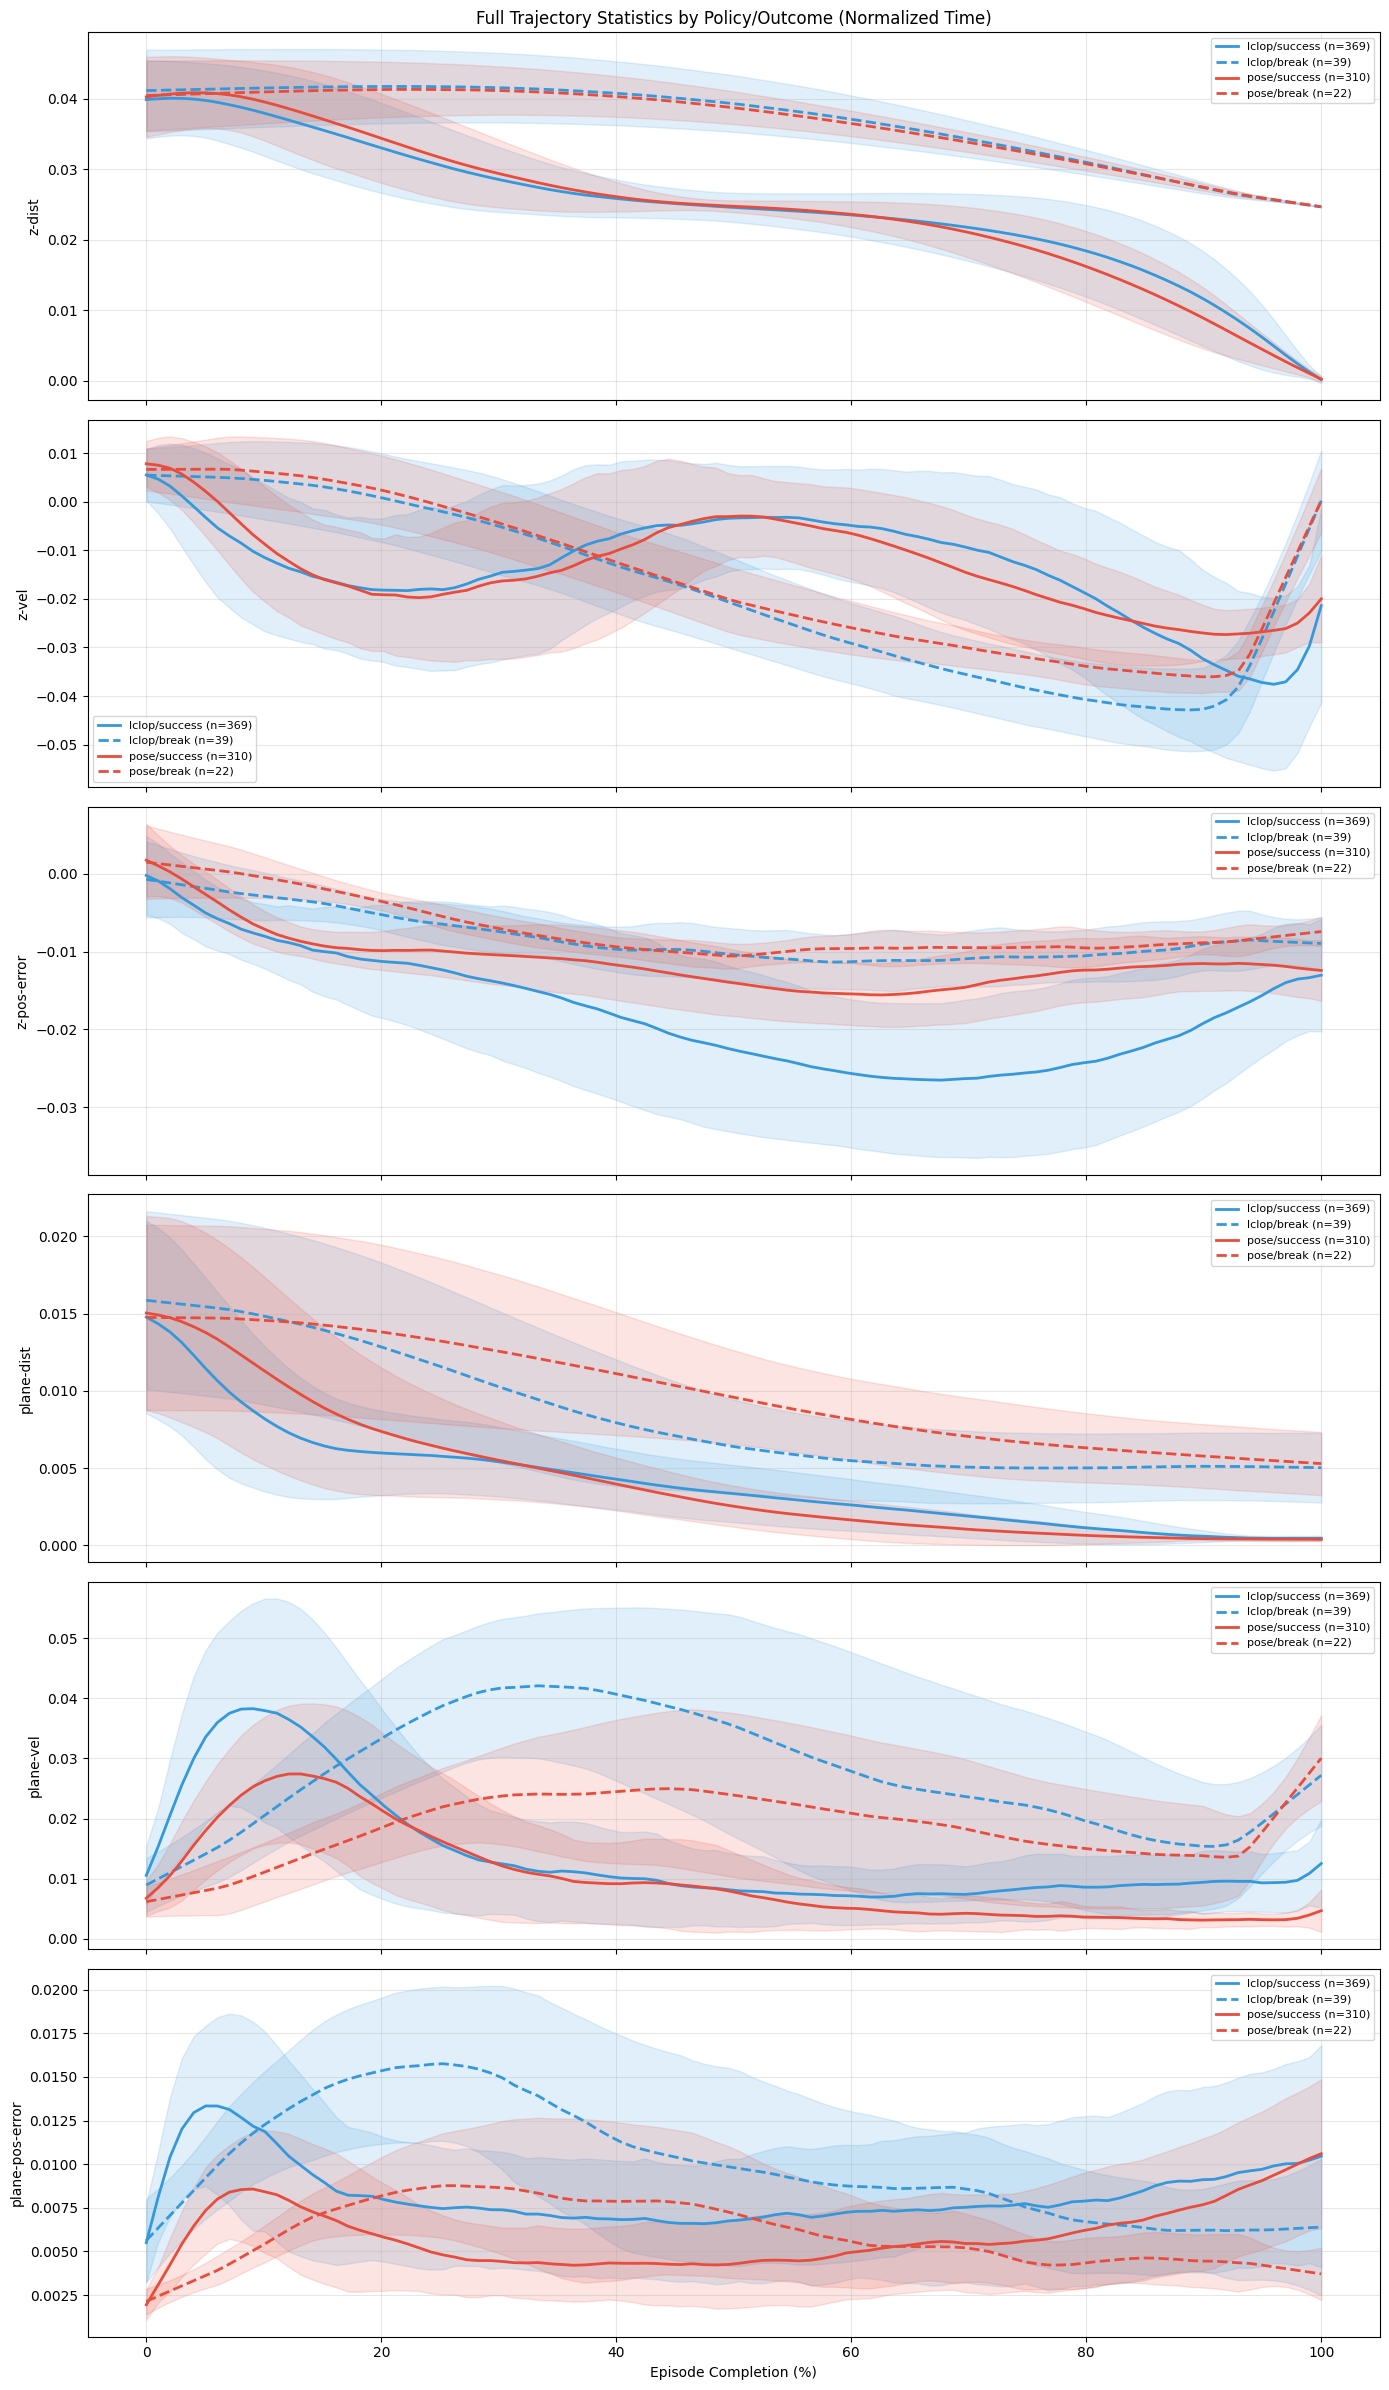

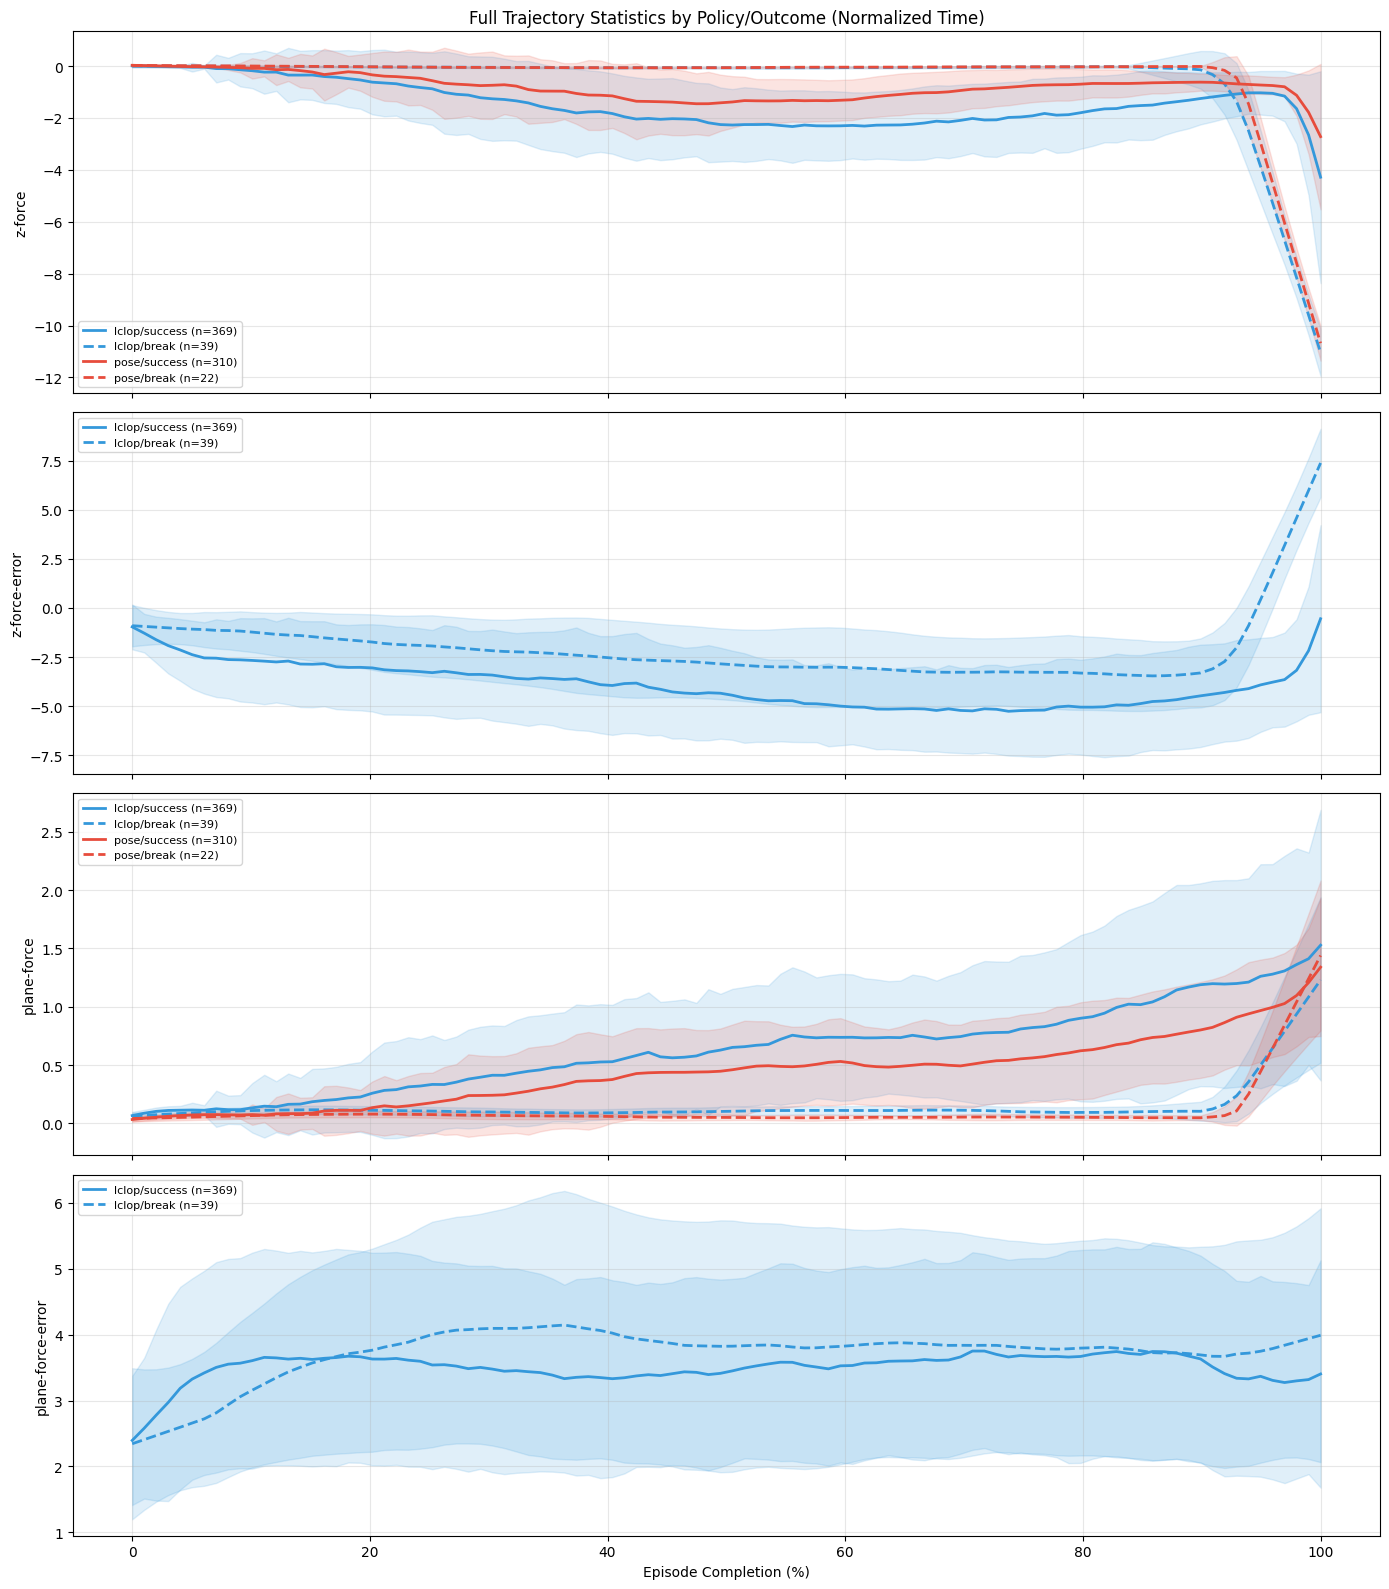

In [51]:
# =============================================================================
# 3b. PHASE TRAJECTORY ANALYSIS
# =============================================================================
def compute_trajectory_variable(
    step: Dict,
    var_name: str,
    hole_pos: Optional[List[float]] = None,
    peg_pos: Optional[List[float]] = None,
    filter_contact: bool = False
) -> Optional[float]:
    """
    Compute a derived variable from step data.
    
    Supported variables:
        Positional (requires hole_pos in episode):
            'plane-dist': XY distance from peg to hole
            'z-dist': Z distance from peg to hole (signed)
            'z-dist-abs': Absolute Z distance
        
        Velocity:
            'plane-vel': XY velocity magnitude
            'z-vel': Z velocity (signed, negative = downward)
        
        Force:
            'plane-force': XY force magnitude
            'z-force': Z force (signed)
            'z-force-abs': Absolute Z force
        
        Position error:
            'plane-pos-error': XY position error magnitude
            'z-pos-error': Z position error
        
        Force error:
            'plane-force-error': XY force error magnitude  
            'z-force-error': Z force error
        
        Control:
            'z-mode': Z control mode (0=pos, 1=force)
            'z-mode-prob': Z force mode probability
    
    Args:
        step: Step dict with standard fields
        var_name: Name of variable to compute
        hole_pos: [x, y, z] position of hole (from episode data)
        peg_pos: [x, y, z] current peg position (from step, if available)
        filter_contact: If True, return None for steps where contact is detected
                        on relevant axes (z for z-*, xy for plane-*)
    
    Returns:
        Computed value or None if not computable
    """
    try:
        # Check contact filtering
        if filter_contact:
            contact_state = step.get('contact_state', [False, False, False])
            if contact_state is None:
                contact_state = [False, False, False]
            
            # Determine which axes matter for this variable
            if var_name.startswith('z-'):
                # Z variables - filter if Z contact
                if contact_state[2]:
                    return None
            elif var_name.startswith('plane-'):
                # Plane variables - filter if X or Y contact
                if contact_state[0] or contact_state[1]:
                    return None
        
        if var_name == 'plane-dist':
            if hole_pos is None or peg_pos is None:
                return None
            dx = peg_pos[0] - hole_pos[0]
            dy = peg_pos[1] - hole_pos[1]
            return np.sqrt(dx**2 + dy**2)
        
        elif var_name == 'z-dist':
            if hole_pos is None or peg_pos is None:
                return None
            return peg_pos[2] - hole_pos[2]
        
        elif var_name == 'z-dist-abs':
            if hole_pos is None or peg_pos is None:
                return None
            return abs(peg_pos[2] - hole_pos[2])
        
        elif var_name == 'plane-vel':
            vel = step.get('velocity')
            if vel is None:
                return None
            return np.sqrt(vel[0]**2 + vel[1]**2)
        
        elif var_name == 'z-vel':
            vel = step.get('velocity')
            if vel is None:
                return None
            return vel[2]
        
        elif var_name == 'plane-force':
            force = step.get('contact_force')
            if force is None:
                return None
            return np.sqrt(force[0]**2 + force[1]**2)
        
        elif var_name == 'z-force':
            force = step.get('contact_force')
            if force is None:
                return None
            return force[2]
        
        elif var_name == 'z-force-abs':
            force = step.get('contact_force')
            if force is None:
                return None
            return abs(force[2])
        
        elif var_name == 'plane-pos-error':
            err = step.get('position_error')
            if err is None:
                return None
            return np.sqrt(err[0]**2 + err[1]**2)
        
        elif var_name == 'z-pos-error':
            err = step.get('position_error')
            if err is None:
                return None
            return err[2]
        
        elif var_name == 'plane-force-error':
            err = step.get('force_error')
            if err is None:
                return None
            return np.sqrt(err[0]**2 + err[1]**2)
        
        elif var_name == 'z-force-error':
            err = step.get('force_error')
            if err is None:
                return None
            return err[2]
        
        elif var_name == 'z-mode':
            sel = step.get('control_selection')
            if sel is None:
                return None
            return sel[2]
        
        elif var_name == 'z-mode-prob':
            prob = step.get('control_probability')
            if prob is None:
                return None
            return prob[2]
        
        else:
            raise ValueError(f"Unknown variable: {var_name}")
    
    except (IndexError, TypeError):
        return None


def plot_phase_trajectories(
    episode_data: List[Dict],
    phase: str,
    variables: List[str],
    filter_contact: bool = False,
    figsize: Tuple[float, float] = None,
    alpha: float = 0.3,
    max_trajectories: int = 100
) -> plt.Figure:
    """
    Plot all trajectories for specified variables within a phase.
    
    Args:
        episode_data: List of episode dicts. Episodes should have 'hole_pos' field
                      if using distance variables. Steps should have 'peg_pos' field.
        phase: Phase to filter ("approaching", "initial_contact", "insertion")
        variables: List of variable names to plot (see compute_trajectory_variable)
        filter_contact: If True, exclude timesteps where contact is detected on
                        relevant axes (z for z-*, xy for plane-*)
        figsize: Figure size (auto-calculated if None)
        alpha: Transparency for trajectory lines
        max_trajectories: Max trajectories per policy to plot (for performance)
    
    Returns:
        matplotlib Figure
    """
    n_vars = len(variables)
    if figsize is None:
        figsize = (14, 4 * n_vars)
    
    fig, axes = plt.subplots(n_vars, 1, figsize=figsize, sharex=True)
    if n_vars == 1:
        axes = [axes]
    
    colors = {'lclop': '#3498db', 'pose': '#e74c3c'}
    
    # Track trajectory counts per policy
    traj_counts = defaultdict(int)
    
    for ep in episode_data:
        policy = ep['policy']
        
        # Limit trajectories for performance
        if traj_counts[policy] >= max_trajectories:
            continue
        
        # Get hole position if available
        hole_pos = ep.get('hole_pos')
        
        # Extract steps in the desired phase
        phase_steps = []
        for step in ep['steps']:
            if step.get('phase') == phase:
                phase_steps.append(step)
        
        if not phase_steps:
            continue
        
        traj_counts[policy] += 1
        color = colors.get(policy, '#95a5a6')
        
        # Time axis: steps since phase entry
        t = np.arange(len(phase_steps))
        
        # Plot each variable
        for ax, var_name in zip(axes, variables):
            values = []
            for step in phase_steps:
                peg_pos = step.get('peg_pos')
                val = compute_trajectory_variable(step, var_name, hole_pos, peg_pos, filter_contact)
                values.append(val)
            
            # Filter out None values for plotting
            valid_t = [ti for ti, v in zip(t, values) if v is not None]
            valid_v = [v for v in values if v is not None]
            
            if valid_v:
                ax.plot(valid_t, valid_v, color=color, alpha=alpha, linewidth=0.8)
    
    # Format axes
    for ax, var_name in zip(axes, variables):
        ax.set_ylabel(var_name)
        ax.grid(alpha=0.3)
    
    title_suffix = ' (no-contact only)' if filter_contact else ''
    axes[0].set_title(f'Trajectories During "{phase}" Phase{title_suffix}')
    axes[-1].set_xlabel('Steps Since Phase Entry')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=c, label=f'{p} (n={traj_counts[p]})') 
        for p, c in colors.items() if traj_counts[p] > 0
    ]
    axes[0].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig


def plot_phase_trajectories_summary(
    episode_data: List[Dict],
    phase: str,
    variables: List[str],
    normalize_time: bool = False,
    n_points: int = 100,
    filter_contact: bool = False,
    figsize: Tuple[float, float] = None
) -> plt.Figure:
    """
    Plot mean ± std trajectories for specified variables within a phase.
    
    Like plot_phase_trajectories but shows aggregated statistics instead of
    individual trajectories.
    
    Args:
        episode_data: List of episode dicts
        phase: Phase to filter
        variables: List of variable names to plot
        normalize_time: If True, interpolate all trajectories to 0-100% phase completion.
                        If False, use raw step counts with NaN padding for shorter trajectories.
        n_points: Number of points to interpolate to when normalize_time=True
        filter_contact: If True, exclude timesteps where contact is detected on
                        relevant axes (z for z-*, xy for plane-*)
        figsize: Figure size (auto-calculated if None)
    
    Returns:
        matplotlib Figure
    """
    n_vars = len(variables)
    if figsize is None:
        figsize = (14, 4 * n_vars)
    
    fig, axes = plt.subplots(n_vars, 1, figsize=figsize, sharex=True)
    if n_vars == 1:
        axes = [axes]
    
    colors = {'lclop': '#3498db', 'pose': '#e74c3c'}
    
    # Collect trajectories by policy
    policy_trajectories = defaultdict(lambda: {var: [] for var in variables})
    
    for ep in episode_data:
        policy = ep['policy']
        hole_pos = ep.get('hole_pos')
        
        # Extract steps in the desired phase
        phase_steps = [s for s in ep['steps'] if s.get('phase') == phase]
        
        if not phase_steps:
            continue
        
        # Compute each variable
        for var_name in variables:
            values = []
            for step in phase_steps:
                peg_pos = step.get('peg_pos')
                val = compute_trajectory_variable(step, var_name, hole_pos, peg_pos, filter_contact)
                values.append(val if val is not None else np.nan)
            
            policy_trajectories[policy][var_name].append(values)
    
    # Plot mean ± std for each policy
    for policy, var_trajs in policy_trajectories.items():
        color = colors.get(policy, '#95a5a6')
        n_trajs = len(var_trajs[variables[0]]) if variables else 0
        
        for ax, var_name in zip(axes, variables):
            trajs = var_trajs[var_name]
            if not trajs:
                continue
            
            if normalize_time:
                # Interpolate all trajectories to common 0-100% scale
                t_norm = np.linspace(0, 100, n_points)
                interpolated = []
                
                for traj in trajs:
                    if len(traj) < 2:
                        continue
                    # Original time as percentage
                    t_orig = np.linspace(0, 100, len(traj))
                    # Interpolate (handle NaN by interpolating only valid segments)
                    traj_arr = np.array(traj)
                    valid_mask = ~np.isnan(traj_arr)
                    if valid_mask.sum() < 2:
                        continue
                    # Simple linear interpolation
                    interp_vals = np.interp(t_norm, t_orig, traj_arr, left=np.nan, right=np.nan)
                    interpolated.append(interp_vals)
                
                if not interpolated:
                    continue
                
                aligned = np.array(interpolated)
                t = t_norm
                xlabel = 'Phase Completion (%)'
            else:
                # Pad shorter trajectories with NaN to match longest
                max_len = max(len(tr) for tr in trajs)
                aligned = np.full((len(trajs), max_len), np.nan)
                for i, tr in enumerate(trajs):
                    aligned[i, :len(tr)] = tr
                
                t = np.arange(max_len)
                xlabel = 'Steps Since Phase Entry'
            
            # Compute stats (ignoring NaN)
            with np.errstate(all='ignore'):
                mean = np.nanmean(aligned, axis=0)
                std = np.nanstd(aligned, axis=0)
                # Count non-NaN values at each timestep for transparency
                count = np.sum(~np.isnan(aligned), axis=0)
            
            # Plot mean line
            ax.plot(t, mean, color=color, label=f'{policy} (n={n_trajs})', linewidth=2)
            
            # Plot std band with alpha based on sample count
            # More transparent where fewer trajectories contribute
            if not normalize_time:
                # Variable alpha based on how many trajectories contribute
                max_count = count.max()
                for i in range(len(t) - 1):
                    alpha = 0.3 * (count[i] / max_count) if max_count > 0 else 0.1
                    ax.fill_between(
                        t[i:i+2], 
                        (mean - std)[i:i+2], 
                        (mean + std)[i:i+2], 
                        color=color, 
                        alpha=alpha,
                        linewidth=0
                    )
            else:
                ax.fill_between(t, mean - std, mean + std, color=color, alpha=0.2)
    
    # Format axes
    for ax, var_name in zip(axes, variables):
        ax.set_ylabel(var_name)
        ax.grid(alpha=0.3)
        ax.legend()
    
    title_suffix = ' (Normalized Time)' if normalize_time else ' (Raw Steps)'
    if filter_contact:
        title_suffix += ' (no-contact only)'
    axes[0].set_title(f'Trajectory Statistics During "{phase}" Phase{title_suffix}')
    axes[-1].set_xlabel('Phase Completion (%)' if normalize_time else 'Steps Since Phase Entry')
    
    plt.tight_layout()
    return fig


def plot_full_trajectories(
    episode_data: List[Dict],
    variables: List[str],
    outcomes: List[str] = None,
    filter_contact: bool = False,
    figsize: Tuple[float, float] = None,
    alpha: float = 0.3,
    max_trajectories_per_group: int = 50
) -> plt.Figure:
    """
    Plot all full trajectories (not filtered by phase), colored by policy and outcome.
    
    Args:
        episode_data: List of episode dicts
        variables: List of variable names to plot
        outcomes: List of outcomes to include (default: ['success', 'break'])
        filter_contact: If True, exclude timesteps where contact is detected on
                        relevant axes (z for z-*, xy for plane-*)
        figsize: Figure size (auto-calculated if None)
        alpha: Transparency for trajectory lines
        max_trajectories_per_group: Max trajectories per policy+outcome combo
    
    Returns:
        matplotlib Figure
    """
    if outcomes is None:
        outcomes = ['success', 'break']
    
    n_vars = len(variables)
    if figsize is None:
        figsize = (14, 4 * n_vars)
    
    fig, axes = plt.subplots(n_vars, 1, figsize=figsize, sharex=True)
    if n_vars == 1:
        axes = [axes]
    
    # Color scheme: policy determines hue, outcome determines shade
    color_map = {
        ('lclop', 'success'): '#3498db',    # blue
        ('lclop', 'break'): '#1a5276',      # dark blue
        ('lclop', 'timeout'): '#85c1e9',    # light blue
        ('pose', 'success'): '#e74c3c',     # red
        ('pose', 'break'): '#922b21',       # dark red
        ('pose', 'timeout'): '#f1948a',     # light red
    }
    
    # Track counts per group
    group_counts = defaultdict(int)
    plotted_counts = defaultdict(int)
    
    for ep in episode_data:
        policy = ep['policy']
        outcome = ep['outcome']
        
        if outcome not in outcomes:
            continue
        
        group_key = (policy, outcome)
        group_counts[group_key] += 1
        
        if plotted_counts[group_key] >= max_trajectories_per_group:
            continue
        
        plotted_counts[group_key] += 1
        
        hole_pos = ep.get('hole_pos')
        steps = ep['steps']
        
        if not steps:
            continue
        
        color = color_map.get(group_key, '#95a5a6')
        t = np.arange(len(steps))
        
        for ax, var_name in zip(axes, variables):
            values = []
            for step in steps:
                peg_pos = step.get('peg_pos')
                val = compute_trajectory_variable(step, var_name, hole_pos, peg_pos, filter_contact)
                values.append(val)
            
            valid_t = [ti for ti, v in zip(t, values) if v is not None]
            valid_v = [v for v in values if v is not None]
            
            if valid_v:
                ax.plot(valid_t, valid_v, color=color, alpha=alpha, linewidth=0.8)
    
    # Format axes
    for ax, var_name in zip(axes, variables):
        ax.set_ylabel(var_name)
        ax.grid(alpha=0.3)
    
    title_suffix = ' (no-contact only)' if filter_contact else ''
    axes[0].set_title(f'Full Trajectories by Policy and Outcome{title_suffix}')
    axes[-1].set_xlabel('Step')
    
    # Build legend
    from matplotlib.lines import Line2D
    legend_elements = []
    for (policy, outcome), count in sorted(group_counts.items()):
        if outcome in outcomes:
            color = color_map.get((policy, outcome), '#95a5a6')
            label = f'{policy}/{outcome} (n={count})'
            legend_elements.append(Line2D([0], [0], color=color, label=label))
    
    axes[0].legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    plt.tight_layout()
    return fig


def plot_full_trajectories_summary(
    episode_data: List[Dict],
    variables: List[str],
    outcomes: List[str] = None,
    normalize_time: bool = False,
    n_points: int = 100,
    split_by_outcome: bool = True,
    filter_contact: bool = False,
    figsize: Tuple[float, float] = None
) -> plt.Figure:
    """
    Plot mean ± std for full trajectories, with options to split by outcome.
    
    Args:
        episode_data: List of episode dicts
        variables: List of variable names to plot
        outcomes: List of outcomes to include (default: ['success', 'break'])
        normalize_time: If True, interpolate to 0-100% episode completion
        n_points: Interpolation resolution when normalize_time=True
        split_by_outcome: If True, separate lines for each policy+outcome combo.
                          If False, aggregate all outcomes per policy.
        filter_contact: If True, exclude timesteps where contact is detected on
                        relevant axes (z for z-*, xy for plane-*)
        figsize: Figure size (auto-calculated if None)
    
    Returns:
        matplotlib Figure
    """
    if outcomes is None:
        outcomes = ['success', 'break']
    
    n_vars = len(variables)
    if figsize is None:
        figsize = (14, 4 * n_vars)
    
    fig, axes = plt.subplots(n_vars, 1, figsize=figsize, sharex=True)
    if n_vars == 1:
        axes = [axes]
    
    # Color and style scheme
    if split_by_outcome:
        color_map = {
            ('lclop', 'success'): ('#3498db', '-'),     # blue solid
            ('lclop', 'break'): ('#3498db', '--'),      # blue dashed
            ('lclop', 'timeout'): ('#3498db', ':'),     # blue dotted
            ('pose', 'success'): ('#e74c3c', '-'),      # red solid
            ('pose', 'break'): ('#e74c3c', '--'),       # red dashed
            ('pose', 'timeout'): ('#e74c3c', ':'),      # red dotted
        }
    else:
        color_map = {
            'lclop': ('#3498db', '-'),
            'pose': ('#e74c3c', '-'),
        }
    
    # Collect trajectories
    if split_by_outcome:
        trajectory_groups = defaultdict(lambda: {var: [] for var in variables})
        group_key_fn = lambda ep: (ep['policy'], ep['outcome'])
    else:
        trajectory_groups = defaultdict(lambda: {var: [] for var in variables})
        group_key_fn = lambda ep: ep['policy']
    
    for ep in episode_data:
        if ep['outcome'] not in outcomes:
            continue
        
        group_key = group_key_fn(ep)
        hole_pos = ep.get('hole_pos')
        steps = ep['steps']
        
        if not steps:
            continue
        
        for var_name in variables:
            values = []
            for step in steps:
                peg_pos = step.get('peg_pos')
                val = compute_trajectory_variable(step, var_name, hole_pos, peg_pos, filter_contact)
                values.append(val if val is not None else np.nan)
            
            trajectory_groups[group_key][var_name].append(values)
    
    # Plot each group
    for group_key, var_trajs in trajectory_groups.items():
        if split_by_outcome:
            color, linestyle = color_map.get(group_key, ('#95a5a6', '-'))
            label_base = f'{group_key[0]}/{group_key[1]}'
        else:
            color, linestyle = color_map.get(group_key, ('#95a5a6', '-'))
            label_base = group_key
        
        n_trajs = len(var_trajs[variables[0]]) if variables else 0
        
        for ax, var_name in zip(axes, variables):
            trajs = var_trajs[var_name]
            if not trajs:
                continue
            
            if normalize_time:
                t_norm = np.linspace(0, 100, n_points)
                interpolated = []
                
                for traj in trajs:
                    if len(traj) < 2:
                        continue
                    t_orig = np.linspace(0, 100, len(traj))
                    traj_arr = np.array(traj)
                    valid_mask = ~np.isnan(traj_arr)
                    if valid_mask.sum() < 2:
                        continue
                    interp_vals = np.interp(t_norm, t_orig, traj_arr, left=np.nan, right=np.nan)
                    interpolated.append(interp_vals)
                
                if not interpolated:
                    continue
                
                aligned = np.array(interpolated)
                t = t_norm
            else:
                max_len = max(len(tr) for tr in trajs)
                aligned = np.full((len(trajs), max_len), np.nan)
                for i, tr in enumerate(trajs):
                    aligned[i, :len(tr)] = tr
                t = np.arange(max_len)
            
            with np.errstate(all='ignore'):
                mean = np.nanmean(aligned, axis=0)
                std = np.nanstd(aligned, axis=0)
                count = np.sum(~np.isnan(aligned), axis=0)
            
            ax.plot(t, mean, color=color, linestyle=linestyle, 
                    label=f'{label_base} (n={n_trajs})', linewidth=2)
            
            if not normalize_time:
                max_count = count.max() if count.max() > 0 else 1
                for i in range(len(t) - 1):
                    alpha = 0.3 * (count[i] / max_count)
                    ax.fill_between(
                        t[i:i+2],
                        (mean - std)[i:i+2],
                        (mean + std)[i:i+2],
                        color=color,
                        alpha=alpha,
                        linewidth=0
                    )
            else:
                ax.fill_between(t, mean - std, mean + std, color=color, alpha=0.15)
    
    # Format axes
    for ax, var_name in zip(axes, variables):
        ax.set_ylabel(var_name)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8)
    
    title_suffix = ' (Normalized Time)' if normalize_time else ' (Raw Steps)'
    if filter_contact:
        title_suffix += ' (no-contact only)'
    axes[0].set_title(f'Full Trajectory Statistics by Policy/Outcome{title_suffix}')
    axes[-1].set_xlabel('Episode Completion (%)' if normalize_time else 'Step')
    
    plt.tight_layout()
    return fig


# motion stats
var_groups = [
    ['z-dist','z-vel','z-pos-error','plane-dist','plane-vel','plane-pos-error'],
    ['z-force','z-force-error', 'plane-force', 'plane-force-error']
]

for group in var_groups:
    plot_full_trajectories_summary(
        episode_data,
        variables=group,
        outcomes=['success', 'break'],
        split_by_outcome=True,    # separate lines for success/break
        normalize_time=True       # 0-100% episode completion
    )
    #for phase in ['approaching','initial_contact','insertion']:
        #plot_phase_trajectories(
        #    episode_data,
        #    phase=phase,
        #    variables=group
        #)
        #plot_phase_trajectories_summary(
        #    episode_data,
        #    phase=phase,
        #    variables=group,
        #    outcomes=['success', 'break'],
        #    normalize_time=True
        #)

In [ ]:
# =============================================================================
# 4. IS FORCE CONTROL ACTUALLY WORKING?
# =============================================================================

def plot_force_tracking(
    episode_data: List[Dict],
    figsize: Tuple[float, float] = (10, 8)
) -> plt.Figure:
    """
    Scatter plot of commanded vs actual Z force when force mode is active.
    
    Args:
        episode_data: List of episode dicts. Steps must have 'force_error' and
                      'contact_force'. Assumes commanded = actual + error.
    
    Returns:
        matplotlib Figure
    """
    commanded = []
    actual = []
    
    for ep in episode_data:
        if ep['policy'] != 'lclop':
            continue
        
        for step in ep['steps']:
            if step['control_selection'][2] == 1:  # force mode active on Z
                force_error = step['force_error'][2]
                actual_force = step['contact_force'][2]
                
                if not np.isnan(force_error):
                    commanded.append(actual_force + force_error)
                    actual.append(actual_force)
    
    if not commanded:
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, 'No force control data available', 
                ha='center', va='center', transform=ax.transAxes)
        return fig
    
    commanded = np.array(commanded)
    actual = np.array(actual)
    
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Scatter plot
    axes[0].scatter(commanded, actual, alpha=0.3, s=5)
    
    # Perfect tracking line
    lims = [
        min(commanded.min(), actual.min()),
        max(commanded.max(), actual.max())
    ]
    axes[0].plot(lims, lims, 'r--', label='Perfect tracking')
    axes[0].set_xlabel('Commanded Z Force (N)')
    axes[0].set_ylabel('Actual Z Force (N)')
    axes[0].set_title('Force Controller Tracking Quality')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Error histogram
    errors = actual - commanded
    axes[1].hist(errors, bins=50, alpha=0.7)
    axes[1].axvline(0, color='r', linestyle='--', alpha=0.5)
    axes[1].axvline(errors.mean(), color='g', linestyle='-', 
                    label=f'Mean error: {errors.mean():.3f} N')
    axes[1].set_xlabel('Tracking Error (N)')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Force Tracking Error Distribution (std={errors.std():.3f} N)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_force_error_timeseries(
    episode_data: List[Dict],
    max_episodes: int = 20,
    figsize: Tuple[float, float] = (12, 5)
) -> plt.Figure:
    """
    Time series of force tracking error during insertion phase.
    
    Args:
        episode_data: List of episode dicts.
        max_episodes: Maximum number of episodes to overlay.
    
    Returns:
        matplotlib Figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    episode_count = 0
    
    for ep in episode_data:
        if ep['policy'] != 'lclop':
            continue
        if episode_count >= max_episodes:
            break
        
        errors = []
        for step in ep['steps']:
            if step['phase'] == 'insertion' and step['control_selection'][2] == 1:
                err = step['force_error'][2]
                if not np.isnan(err):
                    errors.append(err)
        
        if errors:
            ax.plot(errors, alpha=0.4, linewidth=0.8)
            episode_count += 1
    
    ax.axhline(0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Steps in Force Control Mode (during insertion)')
    ax.set_ylabel('Z Force Tracking Error (N)')
    ax.set_title('Force Tracking Error During Insertion')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


plot_force_tracking(episode_data)
plot_force_error_timeseries(episode_data)

In [ ]:
# =============================================================================
# 5. UTILITY FUNCTIONS
# =============================================================================

def generate_all_diagnostics(
    episode_data: List[Dict],
    break_events: List[Dict],
    output_dir: str = './diagnostics'
) -> None:
    """
    Generate all diagnostic plots and save to directory.
    
    Args:
        episode_data: List of episode dicts.
        break_events: List of break event dicts with high-res pre-break data.
        output_dir: Directory to save plots.
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    plots = [
        ('break_by_phase', plot_break_count_by_phase, [episode_data]),
        ('break_by_mode', plot_break_count_by_mode, [episode_data]),
        ('force_by_phase', plot_force_by_phase, [episode_data]),
        ('velocity_by_phase', plot_velocity_by_phase, [episode_data]),
        ('prebreak_timeseries', plot_prebreak_timeseries, [break_events]),
        ('prebreak_summary', plot_prebreak_summary, [break_events]),
        ('velocity_at_contact', plot_velocity_at_contact_comparison, [episode_data]),
        ('selection_confidence', plot_selection_confidence_at_contact, [episode_data]),
        ('force_tracking', plot_force_tracking, [episode_data]),
        ('force_error_ts', plot_force_error_timeseries, [episode_data]),
    ]
    
    for name, func, args in plots:
        try:
            fig = func(*args)
            fig.savefig(os.path.join(output_dir, f'{name}.png'), dpi=150, bbox_inches='tight')
            plt.close(fig)
            print(f'Saved {name}.png')
        except Exception as e:
            print(f'Failed to generate {name}: {e}')


def print_break_summary(episode_data: List[Dict]) -> None:
    """
    Print summary statistics about break events.
    """
    stats = defaultdict(lambda: defaultdict(int))
    
    for ep in episode_data:
        policy = ep['policy']
        outcome = ep['outcome']
        stats[policy]['total'] += 1
        stats[policy][outcome] += 1
    
    print("\n" + "="*50)
    print("BREAK RATE SUMMARY")
    print("="*50)
    
    for policy, s in stats.items():
        total = s['total']
        print(f"\n{policy.upper()}:")
        print(f"  Total episodes: {total}")
        for outcome in ['success', 'break', 'timeout']:
            count = s[outcome]  # defaultdict returns 0 for missing keys
            rate = 100 * count / total if total > 0 else 0
            print(f"  {outcome:12s}: {count:4d} ({rate:5.1f}%)")
    
    print("\n" + "="*50)

generate_all_diagnostics(episode_data, break_events) 
print_break_summary(episode_data)